# Take a look at Scania Truck data.
[Database hosted at UCI Machine Learning Repository Site](http://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks#)

There are no label errors. However, nearly every row is missing some kind of measurement. Will need to impute the data one way or another, as dropping rows with any missing measurements leaves only 691 of 60k rows.

In [22]:
def get_nan_frac_cols(df, cutoff = 0.25, graph=True):
    '''
    Returns column labels for columns with a NaN values fraction >= a cutoff fraction.
    Intended use is to visualize how prevalent NaN values are in a dataset.
    ---
    Parameters
    df: Pandas dataframe. Each column represents a feature and its data for all observations.
    cutoff: decimal value, the acceptable fraction of data that can be NaN
    graph: bool, visualizes the data if True
    
    Returns
    List of dataframe column labels that have NaN fraction > cutoff fraction
    '''
    nan_frac_vec, cols_high_nan = [], []
    
    for column in df.columns:
        nan_frac = df[column][df[column].isnull()].size/df.shape[0]
        nan_frac_vec.append(nan_frac)

        if nan_frac >= cutoff:
            cols_high_nan.append(column)
            
    if graph:
        sns.scatterplot(range(df.shape[1]),nan_frac_vec, alpha = 0.9, label='data')
        plt.plot(range(df.shape[1]), np.ones(df.shape[1])*cutoff,'r-', label='Cutoff Threshold')
        plt.legend(loc='best')
        plt.title('Data by column with {}% cutoff'.format(100*cutoff))
        plt.ylabel('Fraction of Values that are NaN')
        plt.xlabel('Column position')
    
    return cols_high_nan

In [65]:
def fit_score_model(features,target,model=DummyClassifier, metric=accuracy_score, params = {}):
    '''
    Function for creating a model instance and getting the desired classification error metric.
    Defaults to sklearn dummy classifier with default parameters
    ----
    Inputs:
    features: array-like object containing features for model fitting
    target: 1-D array-like object cotaining labels for model fitting
    model: sklearn model class or similar that estimates the target value from training data
    metric: function for evaluating an estimator against the true labels.
            Should take arguments (y_true, y_pred) in that order.
    
    Returns:
    score: float value output by metric
    '''
    # Initiate model instance with relevant parameters
    instance = model(**params)
    
    instance.fit(features,target)
    
    # Determine whether to use labels or probabilities when evaluating model
    proba_based_metrics = [log_loss]
    
    if metric in proba_based_metrics:
        return metric(target, instance.predict_proba(features))
    else:
        return metric(target, instance.predict(features))

In [101]:
def scania_score(y_true,y_pred):
    '''
    Calculates Scania's custom score for APS classification problem in heavy trucks.
    Type 2 errors are more heavily penalized, and a lower score is better.
    
    Score is 10*(no. of false positives) + 500*(no. of false negatives)
    Type 1 error represents a mechanic performing an unnecessary inspection.
    Type 2 error represents a failure to identify a faulty truck, possibly resulting in a break-down.
    ---
    Inputs:
    y_true,y_pred: array-like objects of equal length representing true and predicted labels.
    
    Returns:
    float value (>= 0) representing cost of Type 1 and 2 errors in classification.
    '''
    confmat = confusion_matrix(y_train, y_pred)
    
    return confmat[0,1]*10 + confmat[1,0]*500

In [70]:
# Data Containers
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing: standardizing, undersampling, and oversampling, gridsearch
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

# Models: dummy, kNN, logistic regression, Naive Bayes, SVM
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC

# Model evaluation metrics
# ROC curve
# Proprietary cost function
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, log_loss, confusion_matrix

In [3]:
# Original dataset has some text at the top of the csv, above the headers.
# File below has that text removed, leaving only header row and data.
aps = pd.read_csv('./aps_failure_training_set_no_headers.csv')

In [4]:
# Nearly all data enters the dataframe as a string object.
aps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [13]:
# Checking for weird labels
print('Label values:', aps['class'].unique())
mask = aps['class']=='neg'
print('Negative class observations:',aps[mask]['class'].shape[0] )
print('Positive class observations:', aps[~mask]['class'].shape[0])

Label values: ['neg' 'pos']
Negative class observations: 59000
Positive class observations: 1000


In [14]:
# Create new dataframe for EDA
# For each column in dataframe, make that column numeric

X = aps.iloc[:,1:].copy(deep=True)
y = aps['class']

In [15]:
# Convert target variable to numeric

print('Pre-conversion y', y.dtype, y.value_counts(), sep = '\n')
y = pd.Series([0 if lbl == 'neg' else 1 for lbl in y], name = 'class')
print('Post-conversion y', y.dtype, y.value_counts(), sep = '\n')

Pre-conversion y
object
neg    59000
pos     1000
Name: class, dtype: int64
Post-conversion y
int64
0    59000
1     1000
Name: class, dtype: int64


In [16]:
# Convert columns to numeric.
print(X.info())
for column in X.columns:
    X[column]= pd.to_numeric(X[column], errors = 'coerce')
    
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 170 entries, aa_000 to eg_000
dtypes: int64(1), object(169)
memory usage: 77.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 170 entries, aa_000 to eg_000
dtypes: float64(169), int64(1)
memory usage: 77.8 MB
None


Columns above threshold: 28


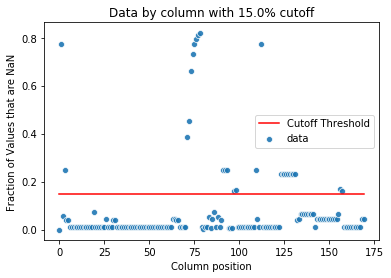

## Dealing with NaN:
Current options:
* drop columns with mostly nan, then drop any row with nan. How many observations do you lose?  
* experiment with sklearn.preprocessing.Imputer
* read sklearn [imputation guide](http://scikit-learn.org/stable/modules/impute.html)
* take mean values
* use kNN with features that aren't null
* determine on which features it would be reasonable to impute

Columns above threshold: 28
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54143 entries, 0 to 59999
Columns: 142 entries, aa_000 to eg_000
dtypes: float64(141), int64(1)
memory usage: 59.1 MB


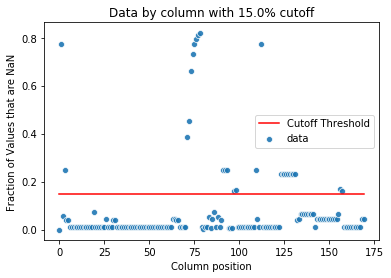

In [27]:
#Dropping idea: Remove columns w/ NaN percent above a threshold, then drop all corresponding rows
nan_cols = get_nan_frac_cols(X, 0.15, graph=True)
print('Columns above threshold:',len(nan_cols))

X_no_nan = X.drop(nan_cols, axis=1).dropna()
X_no_nan.info()

[]

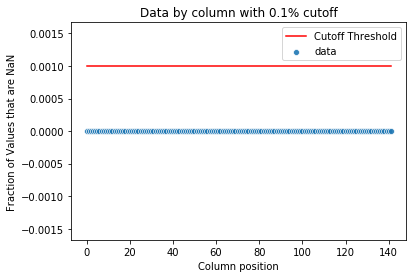

In [32]:
# Visualize the effect
get_nan_frac_cols(X_no_nan, 0.001)

In [34]:
# Check that we still have a good amount of negative and positive classes
y_no_nan = y[X_no_nan.index]
print('Total remaining observations:',y_no_nan.shape[0])
print('Number of negative class:', np.sum(y_no_nan==0))
print('Number of positive class:', y_no_nan[y_no_nan==1].sum())

Total remaining observations: 54143
Number of negative class: 53738
Number of positive class: 405


Dropping high columns with a high percentage of `NaN` values, then culling the observations with any `NaN` value still leaves 54,143 observations, down from 60,000. We also retained 142 of the 170 featurs. However, of the original 1000 positive examples, only 405 remain. The negative class still has 53,738 observations.  

Percent loss, by class, when dropping NaN values:
* Positive class: 59.5%
* Negative class:  0.7%  

Takeaways:  
1) I still have enough examples to train on.  
2) Since the lack of measurements disproportionately affects one class, it could be that the number of missing values is correlated with the class type, and thus should become a feature. To incorporate this, I'd need to impute values (strategically) for the observations that were eliminated.

## Adding database to SQL
Because I don't think it's efficient to write out the 170 columns with their respective types, so I'm going to try to manipulate the columns list into an SQL table creation command.

In [81]:
test = tuple(column + ' col_type' for column in X.columns[:2])
print(test)

('aa_000 col_type', 'ab_000 col_type')


In [83]:
', '.join(thing for thing in test)

'aa_000 col_type, ab_000 col_type'

## Testing Classifiers on Data
Two approach philosophies:
* See which naive model has best performance over K folds, then tune that model to optimal performance.
* Tune every model, to include the number of folds in the data, then evaluate those models over 10 folds.

### Naive Performance of Classifiers
Grab small subsection of data while setting up the pipeline so as not to make the runtime too large. Or don't.

In [ ]:
# Make pipeline object, then 

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_no_nan,y_no_nan, test_size = 0.25, random_state = 42)

In [40]:
# Absolute baseline: Predicting everything as negative
all_neg = np.zeros(len(y_train))
accuracy_score(y_train, all_neg)

0.9923412219568055

In [99]:
# Sklean Dummy Classifier
fit_score_model(X_train,y_train,DummyClassifier, scania_score)

158160

In [107]:
# K Nearest Neighbors
best_k, min_score = None, 1e6
for k in range(1,11):
    knn_params = {'n_neighbors':k}
    score = fit_score_model(X_train,y_train, model=KNeighborsClassifier, metric = scania_score, params=knn_params)
    
    print(k,score)
    
    if score < min_score:
        best_k = k
        min_score = score

print(best_k,min_score)

1 0
2 84500
3 62270
4 91090
5 82370
6 106210
7 95840
8 110690
9 100380
10 109200
1 0


In [109]:
# Logistic Regression
lgr_params = {'C':1}
fit_score_model(X_train, y_train, model = LogisticRegression, metric = scania_score, params = lgr_params)

58840

In [110]:
# Naive Bayes, Gaussian
nb_params = {}
fit_score_model(X_train, y_train, model = GaussianNB, metric = scania_score, params = nb_params)

30100

In [113]:
# Naive Bayes, Multinomial
nb_params = {'alpha':1.0}
fit_score_model(X_train, y_train, model = MultinomialNB, metric = scania_score, params = nb_params)

288800

In [114]:
# Naive Bayes, Bernoulli
nb_params = {'alpha':1.0}
fit_score_model(X_train, y_train, model = BernoulliNB, metric = scania_score, params = nb_params)

59550

In [ ]:
'''
SVM
really fucking slow
kernel options: 'linear', 'poly', 'rbf', 'sigmoid'
paramters: all: 'C'
           'gamma': rbr, poly, sigmoid
           'degree': poly
           'coef0': poly, sigmoid
'''
svc_params = {}
fit_score_model(X_train, y_train, model = SVC, metric = scania_score, params = svc_params)

In [ ]:
# Linear SVM
# kernels: stick with 'linear'
svc_params = {}
fit_score_model(X_train, y_train, model = LinearSVC, metric = scania_score, params = svc_params)

In [108]:
def visualize_score_by_hyperparam(score, hyperparameters):
    # For each hyperparamter, get the model score and plot
    
    pass